# Load DeepFly3D Data

In [1]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera_dict, reprojection_error, intrinsic_matrix
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# declare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D', # change the path 
               'out_dir'        : '/data/LiftPose3D/fly_tether/angle_inv_network',
               'train_subjects' : [1,2,3,4,5],
               'test_subjects'  : [6,7],
               'actions'        : ['all'],
               'cam_id'         : [0,6]}

#intr = intrinsic_matrix(171.0 * 94.0, 171.0 * 94.0, 240, 480) 
#intr = {0: intr,1: intr}
#tvec = {0: np.array([0, 0, 117]), 1: np.array([0, 0, 117])}

#narrow
training_kwargs = {'eangles': {0: [[-30,-20], [-2, 2], [-2,2]], 6: [[-270,-250], [-2, 2], [-2,2]]},
                   'axsorder': 'yxz',
                   'vis': None,
                   'tvec': None,
                   'intr': None}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, train_keypts, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, test_keypts, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Train LiftPose3D Network on DeepFly3D Data

In [2]:
from liftpose.preprocess import obtain_projected_stats
    
stats = obtain_projected_stats(train_3d,
                               training_kwargs['eangles'], 
                               training_kwargs['axsorder'], 
                               training_kwargs['vis'],
                               training_kwargs['tvec'],
                               training_kwargs['intr'],
                               par['roots'], 
                               par['target_sets'],
                               par['out_dir'],
                               load_existing=True,
                               th=1)

[preprocess.py:444]:INFO:Bootstrapping mean and variance...
[preprocess.py:448]:INFO:Loaded existing data.


In [3]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import random_project

aug = random_project(**training_kwargs)

lp3d_train(train_2d=None, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"epochs":10},
           augmentation=[aug],
           stats=stats
          )

/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/preprocess.py:198: RuntimeWarning: invalid value encountered in true_divide
  tmp /= np.linalg.norm(tmp, ord='fro', axis=(1,2), keepdims=True)


[main.py:250]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_tether/angle_inv_network/stat_2d.pth.tar.
[main.py:269]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_tether/angle_inv_network/stat_3d.pth.tar.
[main.py:297]:INFO:Starting training model.
[main.py:307]:DEBUG:
==================Options=================
[main.py:308]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_tether/angle_inv_network',
    'dropout': 0.5,
    'epochs': 10,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_tether/angle_inv_network',
    'out_dir': '/data/LiftPose3D/fly_tether/angle_inv_network',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:309]:DEBUG:==========================================

[lift.py:31]:INFO:Training on

Epoch 000 | LR  0.00081 | Loss Test  0.00000 | Loss Train  0.16157|: 100%|██████████| 11051/11051 [01:19<00:00, 139.25it/s]
Epoch 001 | LR  0.00066 | Loss Test  0.12925 | Loss Train  0.08823|: 100%|██████████| 11051/11051 [01:19<00:00, 138.65it/s]
Epoch 002 | LR  0.00053 | Loss Test  0.12615 | Loss Train  0.08086|: 100%|██████████| 11051/11051 [01:20<00:00, 137.98it/s]
Epoch 003 | LR  0.00043 | Loss Test  0.12335 | Loss Train  0.07672|: 100%|██████████| 11051/11051 [01:20<00:00, 137.44it/s]
Epoch 004 | LR  0.00031 | Loss Test  0.12324 | Loss Train  0.07404|: 100%|██████████| 11051/11051 [01:21<00:00, 136.25it/s]
Epoch 005 | LR  0.00025 | Loss Test  0.12283 | Loss Train  0.07210|: 100%|██████████| 11051/11051 [01:21<00:00, 136.16it/s]
Epoch 006 | LR  0.00021 | Loss Test  0.11790 | Loss Train  0.07069|: 100%|██████████| 11051/11051 [01:21<00:00, 136.24it/s]
Epoch 007 | LR  0.00017 | Loss Test  0.12231 | Loss Train  0.06967|: 100%|██████████| 11051/11051 [01:21<00:00, 135.16it/s]
Epoch 00

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


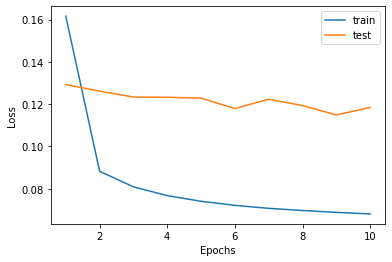

In [4]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [5]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:397]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/angle_inv_network
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:53]:INFO:total params: 4.27M
[lift.py:61]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/angle_inv_network/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 10 | err: 0.06222252427420467)
[lift.py:103]:INFO:Saving results: /data/LiftPose3D/fly_tether/angle_inv_network/test_results.pth.tar


# Visualize Predictions

In [2]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

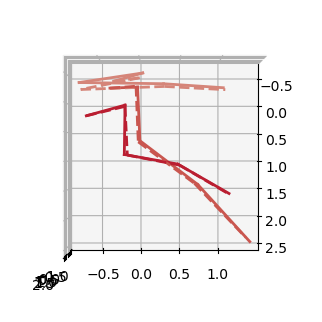

In [7]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=0)

t = 500
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t],
            show_gt_always=False)

# Errors

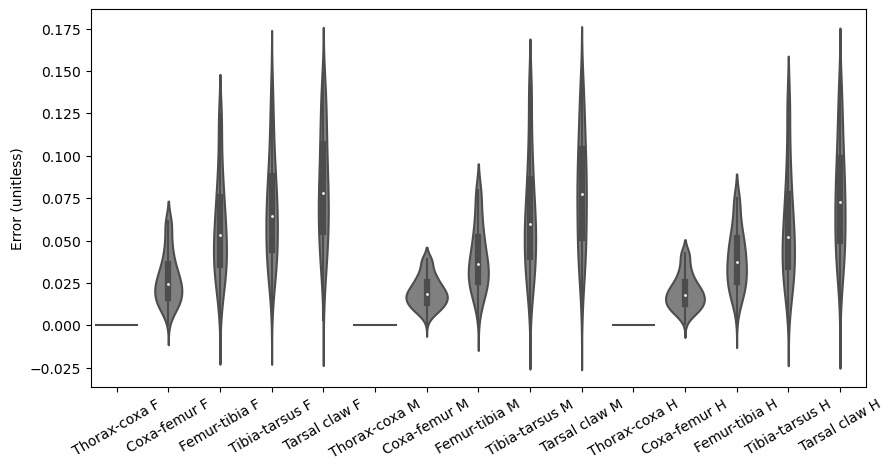

In [3]:
%matplotlib inline
from liftpose.plot import violin_plot
import random, string
plt.figure(figsize=(10,5), dpi=100)
names = ['Thorax-coxa F', 'Coxa-femur F', 'Femur-tibia F', 'Tibia-tarsus F', 'Tarsal claw F',
         'Thorax-coxa M', 'Coxa-femur M', 'Femur-tibia M', 'Tibia-tarsus M', 'Tarsal claw M',
         'Thorax-coxa H', 'Coxa-femur H', 'Femur-tibia H', 'Tibia-tarsus H', 'Tarsal claw H']
ax = plt.gca()
violin_plot(ax, test_3d_gt=test_3d_gt, test_3d_pred=test_3d_pred, test_keypoints=np.ones_like(test_3d_gt),
                joints_name=names, order=names)